<a href="https://colab.research.google.com/github/igorts-git/minesweeper-ai/blob/main/src/Minesweeper_Conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minesweeper solver using convolutions

### Minesweeper engine

The game logic is stored in a separate file `engine.py` on [GitHub](https://github.com/igorts-git/minesweeper-ai/)

Also, in a separate module `ml_dataset.py` (also on GitHub) I put some helper clasess and functions for creating a dataset from randomly generated Minesweeper fields.

Each training sample is represented as a partially opened game board state matrix:
 * Input: each cell is an integer 0..8 represeting the number in that cell or 10 if the cell is hidden.
 * Labels: `1` if the cell has a mine in it, `0` if there is no mine, `-100` if the cell is open. Note that `-100` is a special value for `F.cross_entropy()` that tells it not to compute loss in that cell (because it's open already and its value is known via the input).

In [1]:
# If we are running on Google Colab we need to copy over library modules from this GitHub repo.
!if [ ! -f "./engine.py" ]; then wget "https://raw.githubusercontent.com/igorts-git/minesweeper-ai/main/src/engine.py"; fi;
!if [ ! -f "./ml_dataset.py" ]; then wget "https://raw.githubusercontent.com/igorts-git/minesweeper-ai/main/src/ml_dataset.py"; fi;

In [2]:
import random, time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image

from engine import MinesweeperEngine, CellValue, CELL_STR
import ml_dataset
%matplotlib inline

In [3]:
# We will use GPU if it is available. Training will run several times faster on a GPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device=}")

device='cuda'


The cell below simply tests some basic functionality from the imported modules. It does not contribute to the code below, but it should not fail.

In [4]:
eng = MinesweeperEngine(width=10, height=12, num_mines=40)
eng.partially_open(open_ratio=0.2)
print(eng.to_str(is_view_mask=True))
print(f"{eng.is_game_over=} open_ratio={eng.open_ratio():.2f}")
print(ml_dataset.EngineToInputTensor(eng, device=device))
print(ml_dataset.EngineToLabelsTensor(eng, device=device))

☐ ☐ ☐ ☒ ☐ ☐ ☐ ☒ ☒ ☐
☐ ☐ ☐ ☒ ☐ ☐ ☐ ☒ ☐ ☒
1 ☐ ☐ 5 ☒ ☐ ☐ ☐ ☐ ☒
☒ ☐ ☒ ☒ ☒ ☒ ☒ ☒ ☒ ☒
☐ ☒ ☐ ☒ 4 ☐ ☒ ☐ ☒ ☐
☐ ☒ ☐ ☐ ☐ ☐ ☐ 3 1 1
☒ ☒ ☐ ☐ ☒ ☐ ☒ 2    
☐ ☐ ☒ ☐ ☒ ☒ ☒ 2    
☐ ☐ ☒ ☐ 3 3 3 3 2 1
☐ ☒ ☐ ☒ 1   1 ☒ ☒ ☐
☒ ☐ ☒ ☐ 2 2 3 ☐ ☐ ☐
☐ ☐ 1 ☐ ☐ ☒ ☒ ☐ ☒ ☐
eng.is_game_over=False open_ratio=0.21
tensor([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [ 1, 10, 10,  5, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10,  4, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10,  3,  1,  1],
        [10, 10, 10, 10, 10, 10, 10,  2,  0,  0],
        [10, 10, 10, 10, 10, 10, 10,  2,  0,  0],
        [10, 10, 10, 10,  3,  3,  3,  3,  2,  1],
        [10, 10, 10, 10,  1,  0,  1, 10, 10, 10],
        [10, 10, 10, 10,  2,  2,  3, 10, 10, 10],
        [10, 10,  1, 10, 10, 10, 10, 10, 10, 10]], device='cuda:0')
tensor([[   0,    0,    0,    1,    0,    0,    0,    1,    1,    0],
        [   0,    0,    0,    1, 

### Generate the dataset

When running for the first time, it would take about 10 minutes. On a re-run it would skip generating files that already exist in the `data_dir`.

In [5]:
data_dir = "../data"

In [6]:
%%time
# Training dataset
gen = ml_dataset.DatasetGenerator(width=64, height=64, num_samples_per_file=1000, save_dir=data_dir)
gen.GenerateDataset(num_files=8, override=False)

skipping ../data/minesweeper_64x64_per_file_1000_file_idx_0.pt.gz
skipping ../data/minesweeper_64x64_per_file_1000_file_idx_1.pt.gz
skipping ../data/minesweeper_64x64_per_file_1000_file_idx_2.pt.gz
skipping ../data/minesweeper_64x64_per_file_1000_file_idx_3.pt.gz
generated ../data/minesweeper_64x64_per_file_1000_file_idx_4.pt.gz in 13.75s
generated ../data/minesweeper_64x64_per_file_1000_file_idx_5.pt.gz in 13.60s
generated ../data/minesweeper_64x64_per_file_1000_file_idx_6.pt.gz in 13.65s
generated ../data/minesweeper_64x64_per_file_1000_file_idx_7.pt.gz in 13.67s
CPU times: user 54.4 s, sys: 86 ms, total: 54.5 s
Wall time: 54.7 s


In [7]:
%%time
# Test dataset
gen = ml_dataset.DatasetGenerator(width=128, height=128, num_samples_per_file=32, save_dir=data_dir)
gen.GenerateDataset(num_files=2, override=False)

skipping ../data/minesweeper_128x128_per_file_32_file_idx_0.pt.gz
skipping ../data/minesweeper_128x128_per_file_32_file_idx_1.pt.gz
CPU times: user 0 ns, sys: 925 μs, total: 925 μs
Wall time: 1.53 ms


In [8]:
!du -sh $data_dir

13M	../data


### Create Dataloaders

For each sample that we generated above the dataset loader would produce multiple training sample by flipping and rotating the game board.
If the game board has a square shape, it would produce 8 samples and 4 otherwise.

In [9]:
eval_dataset = ml_dataset.MinesweeperDataset(width=128, height=128, num_samples_per_file=32, data_dir=data_dir)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=512, shuffle=False)
print(f"{len(eval_dataset)=}")
a, b = next(iter(eval_dataloader))
eval_data = (a.to(device), b.to(device))

len(eval_dataset)=512


In [10]:
# We use shuffling built into the dataset reader, because it caches the whole file content in memory.
# Don't let the dataloader shuffle, because it will be prohibitevely slow.
train_dataset = ml_dataset.MinesweeperDataset(width=64, height=64, shuffle=True, data_dir=data_dir)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)
print(f"{len(train_dataset)=} {len(train_dataloader)=}")

len(train_dataset)=64000 len(train_dataloader)=2000


### Create the model

Our model is mostly a series of conv2d layers.

Dropout seems to be important too.

In [11]:
VOCAB_SIZE = max(CellValue) + 1
HIDDEN_WIDTH = 64
OPT_LEARNING_RATE = 5e-4
OPT_WEIGHT_DECAY = 0.01
OPT_BETAS = (0.9, 0.99)
DROPOUT_RATE = 0.1

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, num_channels=HIDDEN_WIDTH, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=kernel_size, padding=padding)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.batch_norm = nn.BatchNorm2d(num_channels)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.dropout(input)
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.tanh(x)
        x = x + input
        return x

class PlayerModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(VOCAB_SIZE, HIDDEN_WIDTH)
        self.conv_blocks = nn.Sequential(
            ConvBlock(),
            ConvBlock(),
            ConvBlock(),
            ConvBlock(),
        )
        self.top_conv = nn.Conv2d(in_channels=HIDDEN_WIDTH, out_channels=2, kernel_size=1, padding=0)

    def forward(self, x: torch.Tensor, targets: torch.Tensor | None = None, print_debug=False) -> torch.Tensor:
        dim = x.ndim
        if dim == 2:
            x = x.unsqueeze(0)

        if print_debug:
            print(f"input shape: {x.shape}")

        x = self.emb(x)
        if print_debug:
            print(f"after emb shape: {x.shape}")

        x = x.permute(0, 3, 1, 2)
        if print_debug:
            print(f"after permute shape: {x.shape}")

        x = self.conv_blocks(x)
        if print_debug:
            print(f"after conv_blocks shape: {x.shape}")

        x = self.top_conv(x)
        if print_debug:
            print(f"after top_conv shape: {x.shape}")

        logits = x
        loss = None
        if targets is not None:
            if targets.ndim == 2:
                targets = targets.unsqueeze(0)
            if print_debug:
                print(f"targets shape: {targets.shape}")
            loss = F.cross_entropy(logits, targets)
        if dim == 2:
            logits = logits.squeeze(0)
        return logits, loss

Let's test our untrained model on one training batch to see that it is not broken (tensor shapes match, etc) and print out the shapes of intermediate tensors.

In [13]:
with torch.no_grad():
    model = PlayerModel().to(device)
    num_params = sum((p.numel() for p in model.parameters()))
    print(f"Number of parameters: {num_params}")
    model.eval()
    X, Y = next(iter(train_dataloader))
    X = X.to(device)
    Y = Y.to(device)
    logits, loss = model(X, targets=Y, print_debug=True)
    print(f"{logits.shape=} {loss.shape=}")

Number of parameters: 149186
input shape: torch.Size([32, 64, 64])
after emb shape: torch.Size([32, 64, 64, 64])
after permute shape: torch.Size([32, 64, 64, 64])
after conv_blocks shape: torch.Size([32, 64, 64, 64])
after top_conv shape: torch.Size([32, 2, 64, 64])
targets shape: torch.Size([32, 64, 64])
logits.shape=torch.Size([32, 2, 64, 64]) loss.shape=torch.Size([])


### Trainer for the model

This is a helper class to drive the training loop.

In [14]:
class Trainer:
    def __init__(self, model: nn.Module, eval_data: tuple[torch.Tensor, torch.Tensor]):
        self.model = model
        self.step_counter = 0
        self.lossi = []  # Loss at every training step
        self.restart_steps = []  # At which step we restarted training.
        self.eval_dataset = eval_data

    def do_train(self, num_steps, train_dataloader, learning_rate=OPT_LEARNING_RATE):
        self.model.train()
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=OPT_WEIGHT_DECAY, betas=OPT_BETAS, eps=1e-8)
        print_freq = num_steps // 15
        self.restart_steps.append(self.step_counter)
        train_iter = iter(train_dataloader)
        for i in range(num_steps):
            start_t = time.time()
            X, Y = next(train_iter)
            X = X.to(device)
            Y = Y.to(device)
            batch_t = time.time()
            optimizer.zero_grad()
            _, loss = self.model(X, targets=Y)
            loss.backward()
            optimizer.step()
            self.lossi.append(loss.log10().item())
            end_t = time.time()
            if i % print_freq == 0:
                step_time = end_t - start_t
                get_batch_time = batch_t - start_t
                get_batch_percent = 100.0 * get_batch_time / step_time
                with torch.no_grad():
                    self.model.eval()
                    X, Y = self.eval_dataset
                    _, eval_loss = self.model(X, targets=Y)
                    self.model.train()
                eval_time = time.time() - end_t
                print(f"{self.step_counter=} {step_time=:.2f} {get_batch_percent=:.1f}% {eval_time=:.2f} {loss.item()=:.4f} {eval_loss.item()=:.4f}")
            self.step_counter += 1

In [15]:
trainer = Trainer(model, eval_data)

### Training loop

Finally, let's train our model. You can run the code below multiple times to see if loss decreases further.

In [16]:
%%time
for _ in range(4):
    trainer.do_train(num_steps=len(train_dataloader), train_dataloader=train_dataloader, learning_rate=OPT_LEARNING_RATE)
    # Re-init the dataset to change the shuffle order
    train_dataset = ml_dataset.MinesweeperDataset(width=64, height=64, shuffle=True, data_dir=data_dir)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)

self.step_counter=0 step_time=0.69 get_batch_percent=72.2% eval_time=0.35 loss.item()=0.8211 eval_loss.item()=1.1180
self.step_counter=133 step_time=0.02 get_batch_percent=9.2% eval_time=0.00 loss.item()=0.5458 eval_loss.item()=0.5278
self.step_counter=266 step_time=0.02 get_batch_percent=10.0% eval_time=0.00 loss.item()=0.4932 eval_loss.item()=0.5155
self.step_counter=399 step_time=0.02 get_batch_percent=8.9% eval_time=0.00 loss.item()=0.5267 eval_loss.item()=0.4982
self.step_counter=532 step_time=0.04 get_batch_percent=46.0% eval_time=0.00 loss.item()=0.5228 eval_loss.item()=0.4953
self.step_counter=665 step_time=0.02 get_batch_percent=9.3% eval_time=0.00 loss.item()=0.4955 eval_loss.item()=0.4921
self.step_counter=798 step_time=0.02 get_batch_percent=9.1% eval_time=0.00 loss.item()=0.4613 eval_loss.item()=0.4855
self.step_counter=931 step_time=0.02 get_batch_percent=9.1% eval_time=0.00 loss.item()=0.5181 eval_loss.item()=0.4809
self.step_counter=1064 step_time=0.02 get_batch_percent

Plot the loss graph. Note, this is log10 of the **training** loss, not eval.

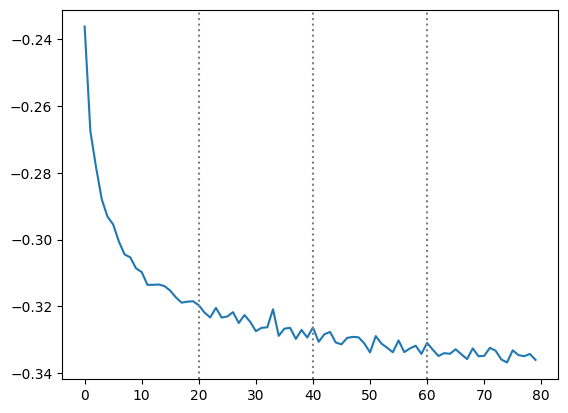

In [17]:
smooth_over_steps = 100
num_trim_losses = len(trainer.lossi) % smooth_over_steps
end_idx = len(trainer.lossi) - num_trim_losses
plt.plot(torch.tensor(trainer.lossi[:end_idx]).view(-1, smooth_over_steps).mean(1))
for x in trainer.restart_steps[1:]:
    plt.axvline(x//smooth_over_steps, linestyle=":", color="grey")

### Let's play!

Now we will see if our model can play Minesweeper.

In [18]:
# This is a helper function for drawing the state of the board based on next move probabilities.
# Black color indicates opened cells. Dark red indicate cells with a high probability of a mine.
# White and bright yellow indicate cells that are safe to open (according to our model).
def show_game_probs(eng: MinesweeperEngine, props: torch.Tensor, colormap='binary', text_color='green', max_cell=None, ax: plt.Axes | None = None):
    image_and_text = [ax.imshow(props.cpu(), cmap=colormap)]
    for y in range(eng.height):
        for x in range(eng.width):
            if eng.view_mask[y][x] != CellValue.EMPTY:
                image_and_text.append(
                    ax.text(x, y, CELL_STR[eng.view_mask[y][x]], ha="center", va="center", color=text_color))
            if max_cell is not None and (x, y) == max_cell:
                image_and_text.append(
                    ax.text(x, y, "*", ha="center", va="center", color="green", backgroundcolor="blue"))
    #plt.show()
    return image_and_text

In [19]:
# This function finds the highest probability unopened cell on the board to make the next move.
# Note: our model was not trained with "FLAG" cells, so we are not going to flag cells with high probability of having mines.
def generate_move(model: nn.Module, eng: MinesweeperEngine, ax: plt.Axes | None=None) -> tuple[int, int, float]:
    with torch.no_grad():
        model.eval()
        tensor = ml_dataset.EngineToInputTensor(eng, device=device)
        logits, _ = model(tensor)
        probs = F.softmax(logits, dim=0)
        mask = ml_dataset.EngineToHiddenMask(eng, device=device).float()

        # mine_prob = probs[1, :, :] * mask
        # show_game_probs(eng, mine_prob, colormap='cool')

        probs = probs[0, :, :] * mask

        max_ind = torch.argmax(probs).item()
        x = max_ind % tensor.shape[1]
        y = max_ind // tensor.shape[1]

        return x, y, probs[y, x].item() * 100.0, show_game_probs(eng, probs, colormap='hot', max_cell=(x,y), ax=ax)

☐ ☐ ☒ 2       2 ☒ ☐ ☐ ☒ ☐ ☐ ☒ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☒ 2       2 ☒ ☐ ☐ ☐ ☐ ☐ ☒ ☒ ☐ ☐ ☐ ☐
☐ ☐ 1 1     1 2 ☐ ☐ ☐ ☒ ☐ ☒ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ 1     1 2 ☒ ☐ ☐ ☒ 2 2 1 ☐ ☐ 2 ☐ ☒ ☐
☐ ☒ 1     2 ☒ ☐ ☐ ☐ 1 1   1 ☐ ☐ ☒ ☒ ☐ ☐
☒ ☐ 2 2 1 3 ☒ ☐ ☐ 1 1     1 ☒ ☐ ☒ ☐ ☐ ☐
☐ ☐ ☒ ☐ ☒ ☐ ☐ ☐ ☐ ☒ 1     1 ☐ ☐ ☒ ☐ ☒ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ 3 1 1 1 ☐ ☒ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☒ ☐ ☒ ☐ ☒ ☐ ☐ ☒ ☐ ☐ ☐ ☒ ☒
☒ ☐ ☒ ☐ ☐ ☐ ☒ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☒
☐ ☐ ☐ ☐ ☐ ☒ ☐ ☐ ☐ ☐ ☐ ☒ ☐ ☐ ☐ ☐ ☐ ☐ ☒ ☒
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☒ ☐ ☒ ☐ ☐ ☐ ☒ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☒ ☐ ☐ ☐ ☐ ☒ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
☐ ☐ ☐ ☐ ☐ ☒ ☐ ☒ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☒ ☐ ☒ ☐
move=1 x=14 y=2 prob=99.84
move=2 x=9 y=3 prob=99.83
move=3 x=10 y=2 prob=99.81
move=4 x=5 y=6 prob=99.76
move=5 x=8 y=3 prob=99.67
move=6 x=8 y=4 prob=99.69
move=7 x=14 y=4 prob=99.65
move=8 x=1 y=1 prob=99.62
move=9 x=14 y=7 prob=99.58
move=10 x=15 y=5 prob=99.41
move=11 x=8 y=2 prob=99.41
move=12 x=8 y=5 prob=99.48
move=13 x=7 y=4 prob=99.74
move=14 x=1 y=2 prob=99.33
move=15 x=8 y=6 prob=99.25

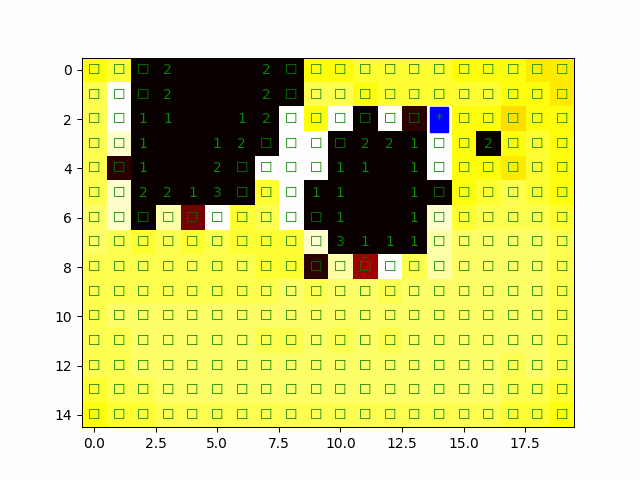

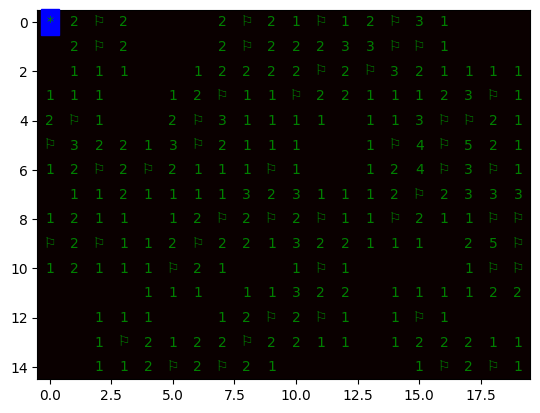

In [20]:
fig, ax = plt.subplots()
eng = MinesweeperEngine(width=20, height=15, num_mines=50)
eng.partially_open(open_ratio=0.1)
print(eng.to_str(is_view_mask=True))
move = 1
images = []
while not eng.is_game_over:
    x, y, prob, img = generate_move(model, eng, ax=ax)
    images.append(img)
    print(f"{move=} {x=} {y=} {prob=:.2f}")
    eng.open_cell(x, y)
    move += 1
print(eng.to_str(is_view_mask=True))
# One more time to generate the last image
_, _, _, img = generate_move(model, eng, ax=ax)
images.append(img)
print("Generating an animation GIF, it will take a few seconds")
ani = animation.ArtistAnimation(fig=fig, artists=images, interval=500, blit=True, repeat_delay=5000)
ani.save('animation.gif', writer='pillow', fps=1)
Image('animation.gif')